<a href="https://colab.research.google.com/github/S4b3/ADM-HW2-Group44/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Imports
---
Uncomment and run those cells if you're working on Cloud and you need to import the dataset!

- Use this on Colab to import your api json
  

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


- Install Kaggle and import then unzip dataset

In [3]:
'''
!pip install pandas
!pip install kaggle
!kaggle datasets download -d najzeko/steam-reviews-2021
!unzip steam-reviews-2021.zip
'''

ERROR: unknown command "installa" - maybe you meant "install"
100% 2.97G/2.97G [00:45<00:00, 67.5MB/s]
100% 2.97G/2.97G [00:45<00:00, 69.7MB/s]
Archive:  steam-reviews-2021.zip
  inflating: steam_reviews.csv       


  # Libraries and Functions imports

In [2]:
import pandas as pd

In [3]:
dataframe = pd.read_csv('./steam_reviews.csv', nrows= 7000000)
print(dataframe.columns)

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')


# [RQ2] Let's explore the dataset by finding simple insights into the reviews.
---

### Plot the number of reviews for each application in descending order.

Text(0, 0.5, 'Reviews Amount')

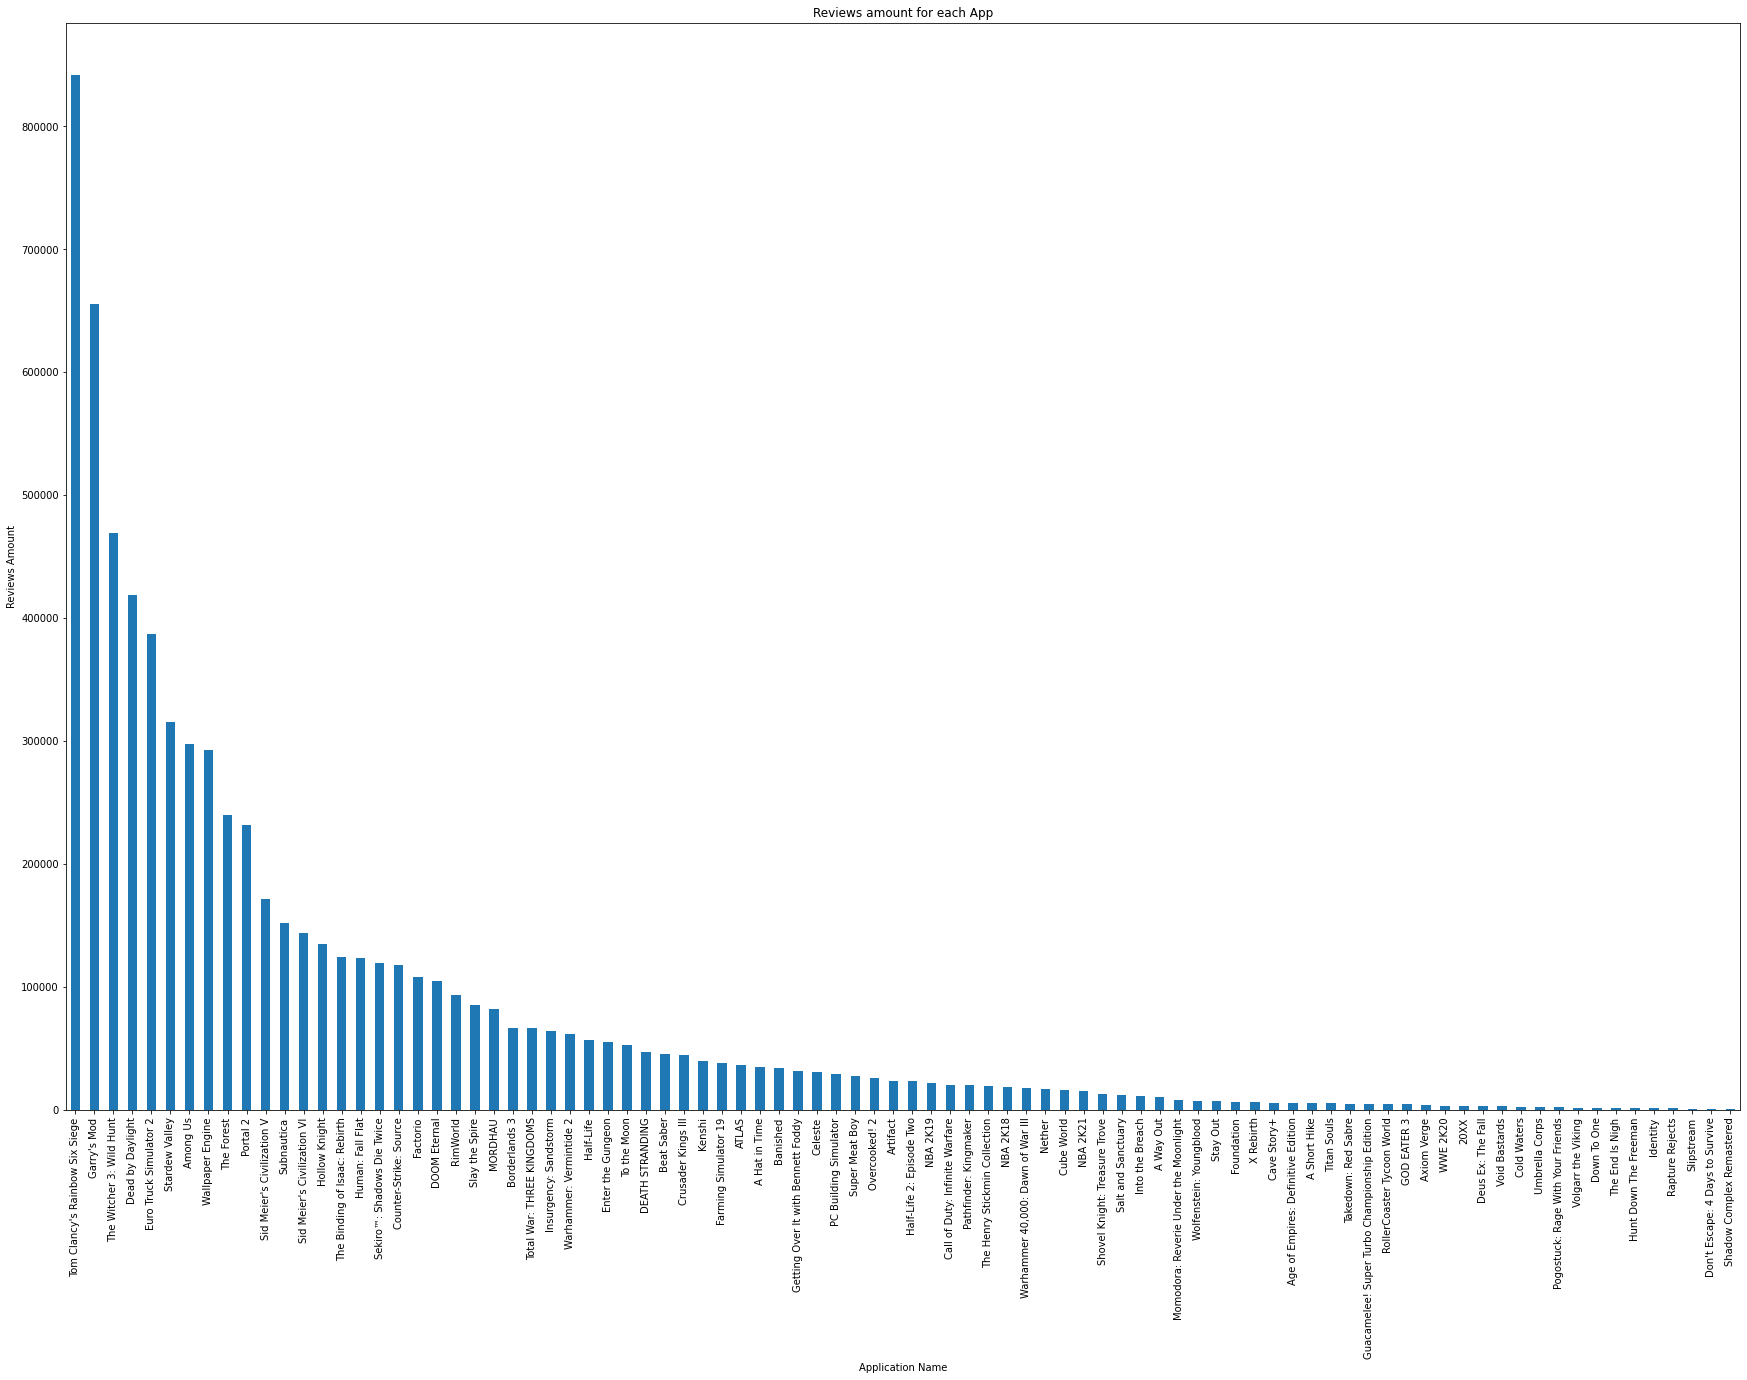

In [17]:
reviewsAmounts = dataframe['app_name'].value_counts()
ra_plot = reviewsAmounts.plot(kind='bar',
                                    figsize=(30,20),
                                    title="Reviews amount for each App")
ra_plot.set_xlabel("Application Name")
ra_plot.set_ylabel("Reviews Amount")
#plt.show()

### Find out are the most and least reviewed applications

In [18]:
print(reviewsAmounts.idxmax())
print(reviewsAmounts.idxmin())

Tom Clancy's Rainbow Six Siege
Shadow Complex Remastered


### What applications have the best Weighted Vote Score?


In [25]:
# daframe.sort_values('weighted_vote_score')
scores = dataframe['weighted_vote_score']
max = scores.idxmax()

print(dataframe[dataframe['weighted_vote_score'] == dataframe['weighted_vote_score'].max()]['app_name'])


5571634    Stardew Valley
Name: app_name, dtype: object


### Which applications have the most and the least recommendations?


In [36]:
recommended = dataframe.groupby('app_name')['recommended'].apply(lambda r : (r == True).sum()).reset_index(name = 'recommendations')
print(recommended[recommended['recommendations'] == recommended['recommendations'].max()]['app_name'])
print(recommended[recommended['recommendations'] == recommended['recommendations'].min()]['app_name'])

77    Tom Clancy's Rainbow Six Siege
Name: app_name, dtype: object
39    Identity
Name: app_name, dtype: object


### How many of these applications were purchased, and how many were given for free?


In [43]:
print((dataframe)['received_for_free'].agg({'Given for free' : lambda x : (x == True).sum(), 'Purchased' : lambda y : (y == False).sum()}))

Given for free     201009
Purchased         6798991
Name: received_for_free, dtype: int64
